# The Kopi Latte Ratio Project: Model Inference

The objective of this notebook is to use the finetuned DistilBERT model for inference on unlabelled reviews

## Load Finetuned Model and Prepare Unlabelled Data for Inference

In [2]:
import os
os.chdir('..')

In [3]:
import pandas as pd
places_unlabelled_df = pd.read_csv('data/interim/places_unlabelled.csv')[['name', 'formatted_address', 'place_id']]
places_unlabelled_df.head()

,name,formatted_address,place_id
0,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",ChIJV6HD-Eo92jERjhfY7NEDrOM
1,Generation Coffee Roasters (Bedok),"216 Bedok North Street 1, #01-32, Singapore 46...",ChIJhbwWY-I92jERxtB-gF22sL0
2,Refuel Cafe,"744 Bedok Reservoir Rd, #01-3029 Reservoir Vil...",ChIJcf_SpPk82jERM28p3SYNBnI
3,Marie's Lapis Cafe,"537 Bedok North Street 3, #01-575, Singapore 4...",ChIJ3Vc6OY092jERhObI1bZ_4Sk
4,COFFEESARANG,"311 New Upper Changi Rd #01-78 Bedok Mall, Sin...",ChIJOb_8OAwj2jERPK-QVelr5Vk


In [5]:
reviews_df = pd.read_csv('data/raw/reviews.csv')[['place_id', 'text']]
reviews_df.head()

,place_id,text
0,ChIJV6HD-Eo92jERjhfY7NEDrOM,It’s great to find a cafe that serves good cof...
1,ChIJV6HD-Eo92jERjhfY7NEDrOM,Nice little independent cafe in Bedok. Quite a...
2,ChIJV6HD-Eo92jERjhfY7NEDrOM,Really blessed this is just around the neighbo...
3,ChIJV6HD-Eo92jERjhfY7NEDrOM,Crowded on a PH morning and I can see why! Cof...
4,ChIJV6HD-Eo92jERjhfY7NEDrOM,This place have very delicious garlic cheese c...


In [7]:
reviews_infer_df = places_unlabelled_df.merge(reviews_df, on='place_id', how='inner')[['text', 'place_id','name', 'formatted_address']]

# drop NaN reviews
reviews_infer_df = reviews_infer_df.dropna(subset=['text']).reset_index(drop=True)
reviews_infer_df.head()

,text,place_id,name,formatted_address
0,It’s great to find a cafe that serves good cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136"
1,Nice little independent cafe in Bedok. Quite a...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136"
2,Really blessed this is just around the neighbo...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136"
3,Crowded on a PH morning and I can see why! Cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136"
4,This place have very delicious garlic cheese c...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136"


## Inference on unlabelled places

In [9]:
from transformers import pipeline

classifier = pipeline("text-classification", model="kopi_latte",device=0)


In [10]:
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
inference_dataset = Dataset.from_pandas(reviews_infer_df)
predictions = []
for out in classifier(KeyDataset(inference_dataset, 'text'), truncation=True):
    predictions.append(out)

In [11]:
# Concatenate predictions to the original dataframe
predictions_df = pd.concat([reviews_infer_df, pd.DataFrame(predictions)], axis=1)
predictions_df

,text,place_id,name,formatted_address,label,score
0,It’s great to find a cafe that serves good cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",CAFE,0.907813
1,Nice little independent cafe in Bedok. Quite a...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",KOPITIAM,0.960808
2,Really blessed this is just around the neighbo...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",CAFE,0.851918
3,Crowded on a PH morning and I can see why! Cof...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",KOPITIAM,0.552938
4,This place have very delicious garlic cheese c...,ChIJV6HD-Eo92jERjhfY7NEDrOM,Percolate,"136 Bedok North Ave 3, #01-152, Singapore 460136",CAFE,0.710723
...,...,...,...,...,...,...
17872,"Very nice desserts, very old school feel.\n\nH...",ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,"418 Yishun Ring Rd, #01-427, Singapore",KOPITIAM,0.554162
17873,Ordered chendol for $2.50. Saw that they have ...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,"418 Yishun Ring Rd, #01-427, Singapore",KOPITIAM,0.664095
17874,Located in a very obscure corner 2 shops away ...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,"418 Yishun Ring Rd, #01-427, Singapore",CAFE,0.588765
17875,My go to place for old school desserts. Portio...,ChIJbRUNKUIU2jERHlin0Niw25M,Huat Heng Desserts,"418 Yishun Ring Rd, #01-427, Singapore",KOPITIAM,0.898605


Each review now has a predicted label. To decide if a place is a cafe or kopitiam, we sum up the number of labels across the location's review

## Aggregate predictions by location and calculate scores for each label

In [12]:
# Sum up the scores by place_id & label
places_predictions_agg = predictions_df.groupby(['place_id','name', 'label'])[['score']].sum().reset_index()
places_predictions_agg.head()

,place_id,name,label,score
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,KOPITIAM,4.824458
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,KOPITIAM,4.671951
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,KOPITIAM,4.721856
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,CAFE,0.880458
4,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,KOPITIAM,3.161445


In [13]:
# convert to wide format, calculate the ratio of CAFE scores to KOPITIAM scores
places_predictions = places_predictions_agg.pivot(index=['place_id', 'name'], columns='label', values='score').reset_index().fillna(0)
places_predictions['ratio'] = places_predictions['CAFE'] / (places_predictions['CAFE'] + places_predictions['KOPITIAM'])
places_predictions.head()

label,place_id,name,CAFE,KOPITIAM,ratio
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,0.000000,4.824458,0.000000
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,0.000000,4.671951,0.000000
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,0.000000,4.721856,0.000000
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,0.880458,3.161445,0.217833
4,ChIJ-1VFVgAX2jERVNhDii9zSCI,煲仔King (Claypot King) @ Serangoon,0.000000,1.966596,0.000000


<Axes: >

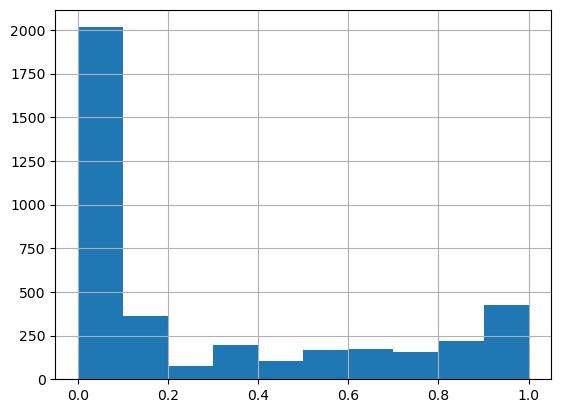

In [14]:
# plot out distribution of score ratio
places_predictions['ratio'].hist()

In [15]:
# bin the scores by 0.1 increments and check the distribution of score ratios
bins = [-1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
places_predictions['ratio_bin'] = pd.cut(places_predictions['ratio'], bins)
places_predictions['ratio_bin'].value_counts().sort_index()

ratio_bin
(-1.0, 0.0]    2015
(0.0, 0.1]        0
(0.1, 0.2]      364
(0.2, 0.3]       77
(0.3, 0.4]      195
(0.4, 0.5]      102
(0.5, 0.6]      170
(0.6, 0.7]      172
(0.7, 0.8]      156
(0.8, 0.9]      219
(0.9, 1.0]      428
Name: count, dtype: int64

Due to the limited time available to manually inspect and classify locations, I will select a threshold of ratio scores to flag out locations for manual checks. 

In [16]:
# bin the scores by quantiles and check the distribution of score ratios
places_predictions['quantile_bin'] = pd.qcut(places_predictions['ratio'], 50, duplicates='drop', labels=False)
places_predictions['quantile_bin'].value_counts().sort_index()

quantile_bin
0     2027
1       78
2       78
3       78
4       78
5       78
6       78
7       78
8       77
9       78
10      78
11      78
12      78
13      78
14      78
15      78
16      78
17      78
18      78
19     468
Name: count, dtype: int64

 A suitable number of places that I'm willing to check for is about 200. Looking at the equal-sized quantile bins, I will flag locations in the middle bins (bins 9-11) as those that need to be manually checked. This amounts to about 234 locations.

## Classify locations using prediction score ratio and flag places for manual classification

In [17]:
import numpy as np

conditions = [(places_predictions['quantile_bin'] ) > 11, (places_predictions['quantile_bin'] ) < 9]
values = ['cafe', 'kopitiam']
places_predictions['review_label'] = np.select(conditions, values, default='unsure')
places_predictions.head()

label,place_id,name,CAFE,KOPITIAM,ratio,ratio_bin,quantile_bin,review_label
0,ChIJ--EXPbAb2jER94utrs6-RuI,Nam Kee Pau,0.000000,4.824458,0.000000,"(-1.0, 0.0]",0,kopitiam
1,ChIJ-0-PEvwR2jERIahkNlKmLRA,Ba Buông Bánh Mì,0.000000,4.671951,0.000000,"(-1.0, 0.0]",0,kopitiam
2,ChIJ-131x5YZ2jERo9zl8Ly76fw,Honolulu Cafe - The Centrepoint (HK Cha Chaan ...,0.000000,4.721856,0.000000,"(-1.0, 0.0]",0,kopitiam
3,ChIJ-1S2tAEj2jERTu0qUzcjqVU,CORNERSHOP,0.880458,3.161445,0.217833,"(0.2, 0.3]",5,kopitiam
4,ChIJ-1VFVgAX2jERVNhDii9zSCI,煲仔King (Claypot King) @ Serangoon,0.000000,1.966596,0.000000,"(-1.0, 0.0]",0,kopitiam


In [18]:
# places_predictions.to_csv('data/interim/places_predictions.csv', index=False)